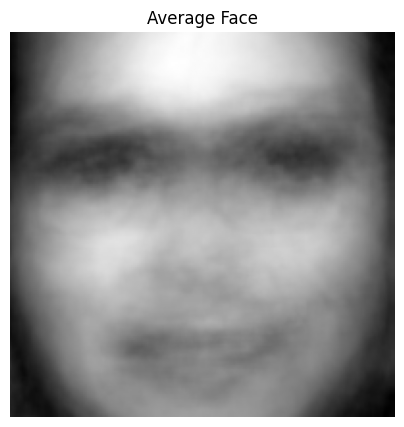

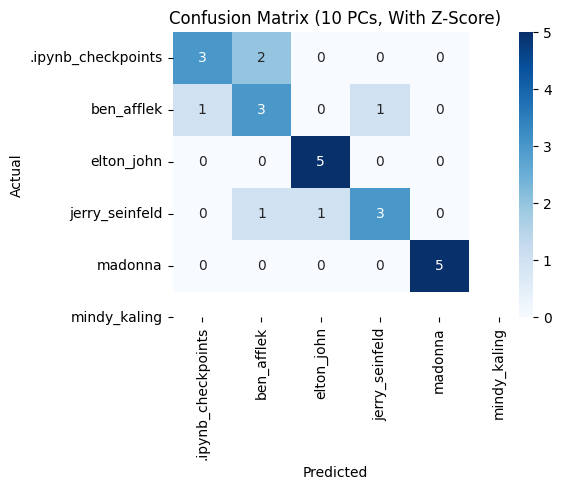


Accuracy Comparison Table:

 Principal Components  Accuracy Without Z-Score (%)  Accuracy With Z-Score (%)
                   10                          76.0                       76.0
                   20                          72.0                       72.0
                   30                          76.0                       76.0
                   40                          72.0                       72.0
                   50                          72.0                       72.0
                   60                          68.0                       68.0
                   70                          60.0                       60.0
                   80                          56.0                       56.0
                   90                          40.0                       40.0


In [7]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Load grayscale images
def load_images(folder):
    X, y = [], []
    label_dict, label_counter = {}, 0
    image_shape = None

    for person_name in sorted(os.listdir(folder)):
        person_folder = os.path.join(folder, person_name)
        if not os.path.isdir(person_folder): continue
        if person_name not in label_dict:
            label_dict[person_name] = label_counter
            label_counter += 1
        label = label_dict[person_name]
        for image_file in glob.glob(os.path.join(person_folder, "*.jpg")):
            img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                if image_shape is None:
                    image_shape = img.shape
                X.append(img.flatten())
                y.append(label)
    return np.array(X), np.array(y), label_dict, image_shape

# Define dataset paths
train_path = "data/train"
val_path = "data/val"

# Load datasets
X_train, y_train, label_dict, image_shape = load_images(train_path)
X_val, y_val, _, _ = load_images(val_path)

# Apply PCA and Naive Bayes with/without Z-Score
pcs = list(range(10, min(X_train.shape[0], 91), 10))
acc_with_z, acc_without_z = [], []

for n_pc in pcs:
    pca = PCA(n_components=n_pc, whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    # Without Z-score
    clf_raw = GaussianNB()
    clf_raw.fit(X_train_pca, y_train)
    y_pred_raw = clf_raw.predict(X_val_pca)
    acc_without_z.append(accuracy_score(y_val, y_pred_raw) * 100)

    # With Z-score
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_val_scaled = scaler.transform(X_val_pca)

    clf_z = GaussianNB()
    clf_z.fit(X_train_scaled, y_train)
    y_pred_z = clf_z.predict(X_val_scaled)
    acc_with_z.append(accuracy_score(y_val, y_pred_z) * 100)

# Average Face
mean_face = np.mean(X_train, axis=0).reshape(image_shape)
plt.figure(figsize=(5, 5))
plt.imshow(mean_face, cmap='gray')
plt.title("Average Face")
plt.axis('off')
plt.show()

# Confusion Matrix
best_pca = PCA(n_components=pcs[0])
X_train_pca = best_pca.fit_transform(X_train)
X_val_pca = best_pca.transform(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)

clf = GaussianNB()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_val_scaled)

conf_matrix = confusion_matrix(y_val, y_pred)
label_names = [name for name, idx in sorted(label_dict.items(), key=lambda x: x[1])]

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title(f"Confusion Matrix ({pcs[0]} PCs, With Z-Score)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# 5. Accuracy Table
df_accuracy = pd.DataFrame({
    "Principal Components": pcs,
    "Accuracy Without Z-Score (%)": acc_without_z,
    "Accuracy With Z-Score (%)": acc_with_z
})
print("\nAccuracy Comparison Table:\n")
print(df_accuracy.to_string(index=False))

